# Part 2: Preprocessing & Modeling

## Imports

In [22]:
import pandas                        as pd
import numpy                         as np
import seaborn                       as sns
import matplotlib.pyplot             as plt
from sklearn.ensemble                import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model            import LogisticRegression
from sklearn.metrics                 import confusion_matrix
from sklearn.model_selection         import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline                import Pipeline
from sklearn.tree                    import DecisionTreeClassifier
from sklearn.neighbors               import KNeighborsClassifier
from nltk.stem                       import WordNetLemmatizer
from nltk.tokenize                   import RegexpTokenizer 
from IPython.core.display            import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
sns.set(style = "white", palette = "deep")
%matplotlib inline

## Table Of Contents

-------

1. [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)
    - [Visuals](#Visuals)
    
    
2. [Lemmatizing](#Lemmatizing)


3. [Establishing The Baseline](#Establishing-The-Baseline)


4. [Modeling](#Modeling)
    - [Setting The X and y variables](#Setting-The-X-and-y-variables)
    - [Running A Train-Test Split](#Running-A-Train-Test-Split)

## Reading In The Data

### Overview

In [2]:
model_data = pd.read_csv("../Data/model_data.csv")

In [3]:
# Checking the data's head

model_data.head()

,id,author,source,text,target
0,cbl354,bobs_aspergers,cooking,Does anyone else immediately distrust a recipe...,1
1,cbtuhn,Swigart,cooking,Mortar amp Pestle questions Is marble dust sa...,1
2,cbmrz3,chuy1530,cooking,Weekly menusetting has changed my life Ive alw...,1
3,cb5pvy,Svargas05,cooking,This guy in India has a cooking channel where ...,1
4,cbjt6n,Tg8402,cooking,How do you sear a steak without filling your k...,1


In [4]:
# Checking for null values

model_data.isnull().sum()

id        0
author    0
source    0
text      0
target    0
dtype: int64

In [5]:
# Checking data types

model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 5 columns):
id        3231 non-null object
author    3231 non-null object
source    3231 non-null object
text      3231 non-null object
target    3231 non-null int64
dtypes: int64(1), object(4)
memory usage: 126.3+ KB


### Visuals

#### Functions

In [6]:
def plot_text_length_dist(list):
    plt.figure(figsize = (18,6))
    sns.distplot(list, kde = False, color = "black",
                 bins = 60)
    plt.title(f"Distribution Of Text Lengths", size = 18)
    plt.xlabel("Length", size = 16)
    plt.ylabel("Frequency", size = 16)
    plt.xticks(np.arange(0,23500,1500), size = 14)
    plt.yticks(size = 14)
    plt.tight_layout()
    plt.show();

In [7]:
def plot_most_frequent_authors(df, col):
    
    plt.figure(figsize = (20,6))
    sns.barplot(x = df.index,
                y = col,
                data = df)
    plt.title("Most Common Posters", size = 18)
    plt.xlabel("Reddit User", size = 16)
    plt.ylabel("Number Of Posts", size = 16)
    plt.xticks(size = 13)
    plt.yticks(size = 14);

#### Text Length

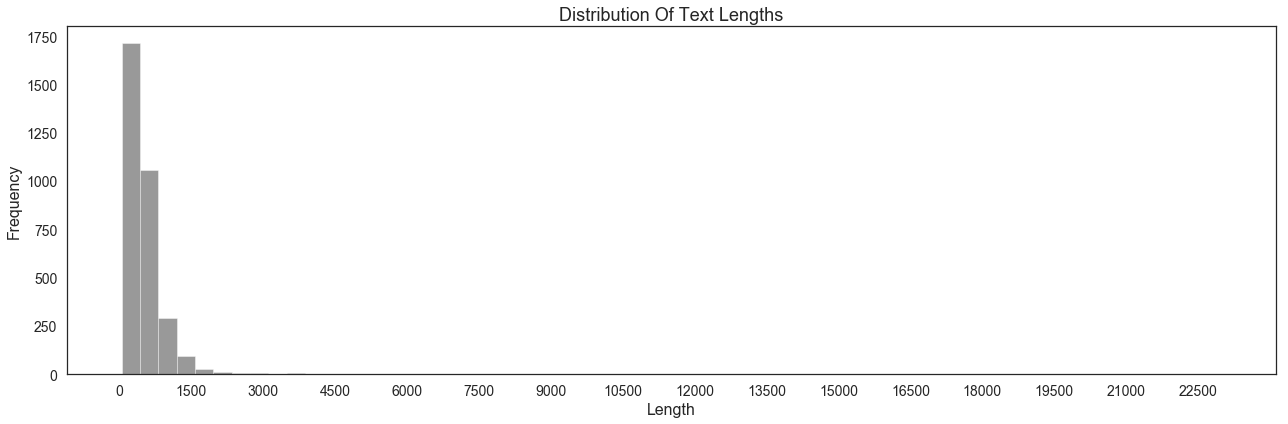

In [8]:
# Generating a list of text lengths

length_list = [len(text) for text in model_data["text"]]

plot_text_length_dist(length_list)

Most of the posts are relatively short (<2000 words), but there are a few that are extremely long (>20,000 words.)  We expected that most posts would be less than a few thousand words, which is true for the majority.

####  Most Frequent Authors

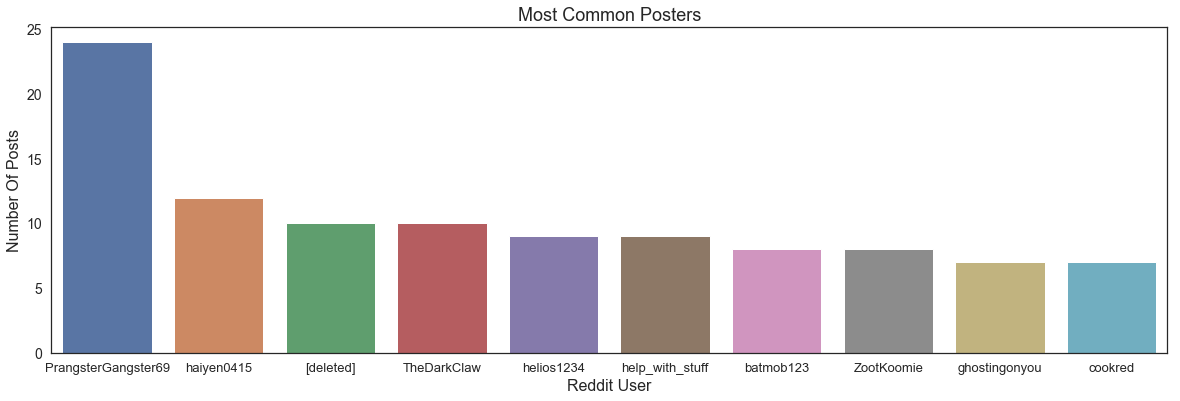

In [9]:
author_count = pd.DataFrame(model_data["author"].value_counts().head(10))

plot_most_frequent_authors(df  = author_count, 
                           col = "author")

We did not really know what to expect when we plotted this graph, because it is generally the case that a few users post most frequently and most barely post at all.  We would have like to look at the number of comments by each user in both subreddits as a measure of activity, but that is beyond the scope of this project.

#### Subreddit Of Origin

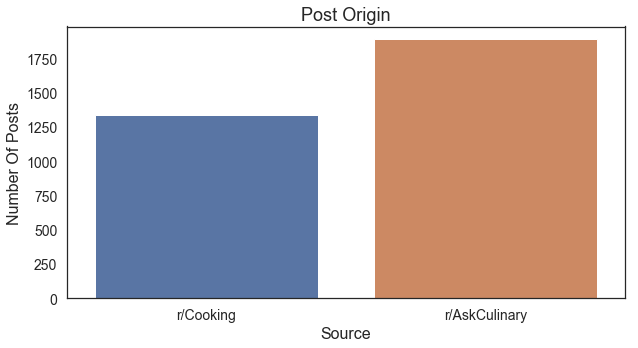

In [10]:
tick_labels = ["r/Cooking", "r/AskCulinary"]


plt.figure(figsize = (10,5))
sns.countplot(model_data["source"])
plt.title("Post Origin", size = 18)
plt.xlabel("Source", size = 16)
plt.ylabel("Number Of Posts", size = 16)
plt.xticks(np.arange(0,2,1), 
           labels = tick_labels, 
           size = 14)
plt.yticks(size = 14);

We were a little surprised that there are more r/AskCulinary posts because we had roughly equal numbers of pulls from each subreddit.

#### Visualizing Most Common Words

Before we start modeling, we need to know what the most frequent words are in each subreddit are because it might be harder for our model to predict with those words in the dataframe.

We will subset the data frame into posts from r/Cooking and r/AskCulinary and use count vectorizer to determine the most frequent words.  We will also remove stop words from the outset.

In [11]:
def plot_most_frequent_words(dataframes, titles):
    count = 0
    fig   = plt.figure(figsize = (24,20))
    for d, dataframe in enumerate(dataframes):
        count += 1
        ax    = fig.add_subplot(2, 2, count)
        sns.barplot(x       = 0,
                    y       = dataframe.index,
                    data    = dataframe,
                    palette = "deep")
        plt.title(f"Most Common Words From {titles[d]}", size = 20)
        plt.xlabel("Word", size = 18)
        plt.ylabel("Number Of Occurrences", size = 18)
        plt.xticks(size = 16)
        plt.yticks(size = 16)

In [12]:
# Instantiating the count vectorizer

vectorizer = CountVectorizer()

# Masking the vectorizer with English stop words

cvec_cooking     = CountVectorizer(stop_words = "english")
cvec_askculinary = CountVectorizer(stop_words = "english")

In [13]:
# Subsetting the dataframe

cooking     = model_data[model_data["target"] == 1]
askculinary = model_data[model_data["target"] == 0]

# Fit-transforming the vectorizer

vec_cooking     = cvec_cooking.fit_transform(cooking["text"])
vec_askculinary = cvec_askculinary.fit_transform(askculinary["text"])

In [14]:
# Saving the vectorized dfs to a new dataframe

cooking_vectorized = pd.DataFrame(vec_cooking.toarray(), 
                                  columns = cvec_cooking.get_feature_names())

askculinary_vectorized = pd.DataFrame(vec_askculinary.toarray(), 
                                      columns = cvec_askculinary.get_feature_names())

In [17]:
# Getting the 15 most frequent words from each

vectorized_cooking     = pd.DataFrame(cooking_vectorized.sum().sort_values(ascending = False).head(15))
vectorized_askculinary = pd.DataFrame(askculinary_vectorized.sum().sort_values(ascending = False).head(15))

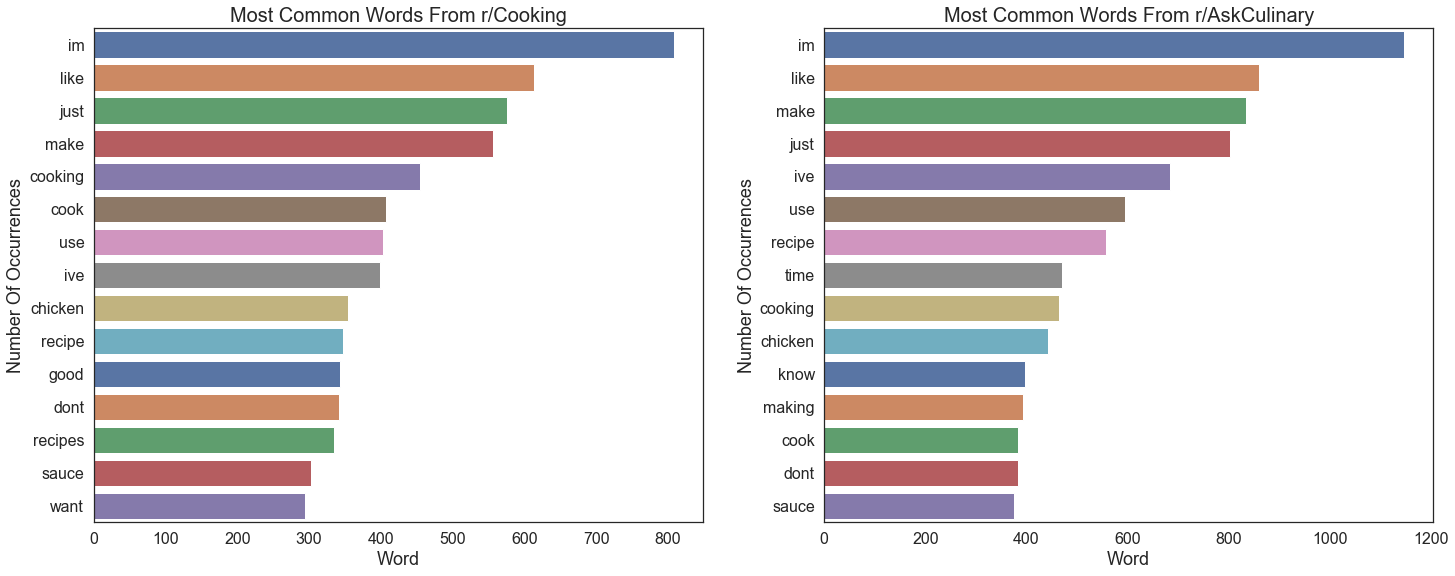

In [18]:
# Plotting the most common words

plot_most_frequent_words(dataframes = [vectorized_cooking, vectorized_askculinary],
                         titles     = ["r/Cooking", "r/AskCulinary"])

We can see that there are a lot of words that occur in both subreddits.  We decided that because of that, we should create a list of customized stop words.  Furthermore, we noticed that we have to lemmatize or stem the text columns because of there are multiple forms of words in the most frequent words such as 'make' & 'making' or 'recipe' and recipes.

## Lemmatizing

We felt that lemmatizing is a better option than stemming because the lemma form of a word is more likely to result in an actual word of English than trying to find a word's stem: there are so many irregularities in English that it is not always easy to find the stem.

In [31]:
# Instantiating the lemmatizier and tokenizer
# The tokenizer will only keep text

lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

# Setting up the lemmatizer

lemmatized_posts = []

for post in model_data["text"]:
    tokens = tokenizer.tokenize(post)
    post  = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts.append(" ".join(post))
    
# Appending the lemmatized posts to the dataframe

model_data["lemmatized_text"] = lemmatized_posts

# Checking the head of the dataframe

model_data.head()

,id,author,source,text,target,lemmatized_text
0,cbl354,bobs_aspergers,cooking,Does anyone else immediately distrust a recipe...,1,Does anyone else immediately distrust a recipe...
1,cbtuhn,Swigart,cooking,Mortar amp Pestle questions Is marble dust sa...,1,Mortar amp Pestle question Is marble dust safe...
2,cbmrz3,chuy1530,cooking,Weekly menusetting has changed my life Ive alw...,1,Weekly menusetting ha changed my life Ive alwa...
3,cb5pvy,Svargas05,cooking,This guy in India has a cooking channel where ...,1,This guy in India ha a cooking channel where h...
4,cbjt6n,Tg8402,cooking,How do you sear a steak without filling your k...,1,How do you sear a steak without filling your k...


While checking the results from the cell above, we noticed that in `lemmatized_text` there are some URLs which need to be removed.  We used a regular expression to remove all URLs.

In [38]:
model_data["lemmatized_text"] = model_data["lemmatized_text"].str.replace("http\S+", "")

We can drop the `text` and `source` columns now that we lemmatized and removed URLs from the `lemmatized_text` column and because we have a target column.

In [43]:
model_data.drop(columns = ["text", "source"],
                axis    = 1,
                inplace = True)

# Checking the columns

model_data.columns

Index(['id', 'author', 'target', 'lemmatized_text'], dtype='object')

## Establishing The Baseline

A baseline in classification gives us an idea of how exactly the model is performing.  The baseline is simply the percentage of occurrences of our target in the data as a whole.  In this case it will be what percentage of posts are from r/Cooking.

If our model has an accuracy of >41.44% we know that it is better than simply guessing the class of a post.

In [44]:
round(model_data["target"].value_counts(normalize = True)*100, 2)

0    58.56
1    41.44
Name: target, dtype: float64

## Modeling

Now that our text is in the format we want, we can begin the process of modeling.

There are a few steps we have to do before we start running models: we have to define the X and y variables and run a train-test split on the data.

### Setting The X and y variables

In [45]:
X = model_data["lemmatized_text"]
y = model_data["target"]

### Running A Train-Test Split

A train-test split is important because it allows us to reserve a portion of our data for test so that the model does not see all data before predicting.  In this case we want to preserve the class split, so we will stratify the data to match the distribution of the classes.

In [46]:
# The stratify argument preserves the distribution of classes

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)